In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


Class Definition for SVM

In [ ]:
class SVM:
    def __init__(self):
        self.alpha = None
        self.b = 0
        self.X = None
        self.y = None
        self.X_test = None
        self.y_test = None
        self.n = None
        self.fitted = False
        self.C = None
        self.gamma = None
        self.kernelFunction = None
        self.noInvalids = False
        self.tol = None
        self.train_accuracy = None
        self.test_accuracy = None
        self.train_losses = None
        self.test_losses = None
    
    def kernel(self, x1, x2):
        if self.kernelFunction == 'linear':
            return x1.T @ x2
        else:
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)
    
    def fit(self, X, y, C, tol, kernel, gamma):
        self.X = X
        self.y = y
        self.alpha = np.zeros(X.shape[1])
        self.b = 0
        self.n = X.shape[1]
        self.C = C
        self.fitted = True
        self.kernelFunction = kernel
        self.gamma = gamma
        self.tol = tol
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
    
    def predict(self, X):
        result = 0
        for i in range(self.n):
            result += self.alpha[i] * self.y[i] * self.kernel(self.X[:, i], X)
        return result + self.b
    
    def violatesKKT(self, i):
        y = self.y[i]
        alpha = self.alpha[i]
        g = y * self.predict(self.X[:, i]) - 1
        if alpha < 1e-5:
            return g < 1e-5
        elif abs(alpha - self.C) < 1e-5:
            return g > 1e-5
        else:
            return abs(g) > 1e-5
        
    def violatingIndices(self, a = None):
        violaters = []
        errorsViolaters = []

        nonViolaters = []
        errorsNonViolaters = []

        for i in range(self.n):
            if i == a:
                continue
            if self.violatesKKT(i):
                violaters.append(i)
                errorsViolaters.append(self.predict(self.X[:, i]) - self.y[i])
            else:
                nonViolaters.append(i)
                errorsNonViolaters.append(self.predict(self.X[:, i]) - self.y[i])
        
        I, E_i = None, -float('inf')
        J, E_j = None, -float('inf')

        # print(violaters, errorsViolaters)
        # print(nonViolaters, errorsNonViolaters)
        self.noInvalids = len(violaters) == 0
        if len(violaters) == 0:
            A = nonViolaters
            B = errorsNonViolaters
        elif len(violaters) > 1:
            A = violaters
            B = errorsViolaters
        else:
            A = violaters + nonViolaters
            B = errorsViolaters + errorsNonViolaters

        #print(A, B)
        temp = -float('inf')
        for idx, err in list(zip(A, B)):
            if abs(err) > temp:
                I, E_i = idx, err
                temp = abs(err)
        
        temp = -float('inf')
        for idx, err in list(zip(A, B)):
            if I != idx and abs(err - E_i) > temp:
                J, temp = idx, abs(err - E_i)
        
        return I, J
    

    def hingeLoss(self, X, y):
        y_pred = np.array([(self.predict(bob)) for bob in X.T])
        return np.sum(np.maximum(0, 1 - y * y_pred))

    def train(self, X, y, X_test, y_test, C=1, tol=1e-3, maxIter = 1000, kernel = 'linear', gamma = 1):
        if not self.fitted:
            self.fit(X, y, C, tol, kernel, gamma)

        epoches = []
        breakOff = False


        for _ in range(maxIter):
            #if _ % 10 == 0: print(_)
            i, j = self.violatingIndices()
            if self.y[i] != self.y[j]:  
                L = max(0, self.alpha[j] - self.alpha[i])
                H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
            else:  
                L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                H = min(self.C, self.alpha[i] + self.alpha[j])


            K_ii = self.kernel(self.X[:, i], self.X[:, i])
            K_jj = self.kernel(self.X[:, j], self.X[:, j])
            K_ij = self.kernel(self.X[:, i], self.X[:, j])


            eta = 2 * K_ij - K_ii - K_jj
            while eta >= 0:
                i, j = self.violatingIndices(i)
                if i is None or j is None:
                    breakOff = True
                    break
                K_ii = self.kernel(self.X[:, i], self.X[:, i])
                K_jj = self.kernel(self.X[:, j], self.X[:, j])
                K_ij = self.kernel(self.X[:, i], self.X[:, j])

                eta = 2 * K_ij - K_ii - K_jj

            if breakOff:
                break


            E_i = self.predict(self.X[:, i]) - self.y[i]
            E_j = self.predict(self.X[:, j]) - self.y[j]

            alpha_j_new = self.alpha[j] - self.y[j] * (E_i - E_j) / eta
            alpha_j_new = min(H, max(L, alpha_j_new))

            alpha_i_new = self.alpha[i] + self.y[i] * self.y[j] * (self.alpha[j] - alpha_j_new)

            
            b1 = self.b - E_i - self.y[i] * (alpha_i_new - self.alpha[i]) * K_ii - self.y[j] * (alpha_j_new - self.alpha[j]) * K_ij
            b2 = self.b - E_j - self.y[i] * (alpha_i_new - self.alpha[i]) * K_ij - self.y[j] * (alpha_j_new - self.alpha[j]) * K_jj

            if 0 < alpha_i_new < self.C:
                b_new = b1
            elif 0 < alpha_j_new < self.C:
                b_new = b2
            else:
                b_new = (b1 + b2) / 2
            
            if max(abs(alpha_i_new - self.alpha[i]), abs(alpha_j_new - self.alpha[j])) < self.tol and self.noInvalids:
                break
            self.alpha[i] = alpha_i_new
            self.alpha[j] = alpha_j_new
            self.b = b_new

            y_pred = np.array([np.sign(self.predict(bob)) for bob in self.X.T])
            train_accuracy = np.mean(y_pred == self.y)*100
            y_test_pred = np.array([np.sign(self.predict(bob)) for bob in X_test.T])
            test_accuracy = np.mean(y_test_pred == y_test)*100

            self.test_losses.append(self.hingeLoss(X_test, y_test))
            self.train_losses.append(self.hingeLoss(self.X, self.y))

            if _ % 10 == 0: print(f"Iteration: {_+10}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")
            epoches.append(_)
            self.test_accuracies.append(test_accuracy)
            self.train_accuracies.append(train_accuracy)
            if train_accuracy > 95:
                break



Data Preprocessing

In [17]:
dataset = pd.read_csv('diabetes.csv')
dataset = dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome']]

class_0 = dataset[dataset['Outcome'] == 0]
class_1 = dataset[dataset['Outcome'] == 1]

class_0_under = class_0.sample(len(class_1))

balanced_dataset = pd.concat([class_0_under, class_1])

balanced_dataset = balanced_dataset.sample(frac=1).reset_index(drop=True)

dataset = balanced_dataset
dataset.shape

(536, 6)

In [18]:
scaler = StandardScaler()
dataset.iloc[:, :-1] = scaler.fit_transform(dataset.iloc[:, :-1])
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
y = np.where(y == 1, 1, -1)
print(X.shape, y.shape)


from sklearn.model_selection import train_test_split

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_1 = np.sum(y_train == 1)
train_0 = np.sum(y_train == -1)
test_1 = np.sum(y_test == 1)
test_0 = np.sum(y_test == -1)

print(f"Train set: 1s: {train_1}, -1s: {train_0}")
print(f"Test set: 1s: {test_1}, -1s: {test_0}")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(536, 5) (536,)
Train set: 1s: 214, -1s: 214
Test set: 1s: 54, -1s: 54
(428, 5) (428,) (108, 5) (108,)


C:\Users\rohan\AppData\Local\Temp\ipykernel_22408\1918125806.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.03201435 -1.19538332 -0.61369883 -1.19538332 -0.03201435 -0.03201435
 -0.61369883 -0.32285659 -0.61369883 -0.90454108  2.00388134 -0.32285659
  2.58556582  0.25882789 -0.90454108 -0.61369883  0.84051237  0.25882789
 -0.61369883  0.54967013 -0.03201435 -1.19538332  0.84051237  2.58556582
  0.25882789 -1.19538332 -0.90454108 -1.19538332 -0.32285659 -1.19538332
  0.84051237 -0.90454108  1.13135462  0.25882789 -0.90454108  1.13135462
 -0.90454108 -0.61369883 -0.03201435  0.25882789  0.84051237 -0.90454108
 -0.32285659  1.7130391   0.54967013  1.13135462 -0.61369883  0.25882789
  1.13135462 -1.19538332  1.13135462 -1.19538332 -1.19538332  0.54967013
 -0.90454108 -0.90454108  0.84051237  0.84051237 -0.61369883 -0.90454108
 -0.61369883  0.25882789 -0.32285659 -0.32285659 -0.03201435 -0.61369883
  0.84051237

Training

In [40]:
svm = SVM()
svm.train(X_train.T, y_train, X_test.T, y_test, C=1, tol=1e-4, maxIter=300, kernel='rbf', gamma=1)
y_pred = np.array([np.sign(svm.predict(bob)) for bob in X_train])
y_test_pred = np.array([np.sign(svm.predict(bob)) for bob in X_test])

Iteration: 10, Train Accuracy: 64.95%, Test Accuracy: 69.44%
Iteration: 20, Train Accuracy: 64.49%, Test Accuracy: 65.74%
Iteration: 30, Train Accuracy: 61.45%, Test Accuracy: 60.19%
Iteration: 40, Train Accuracy: 67.99%, Test Accuracy: 64.81%
Iteration: 50, Train Accuracy: 67.52%, Test Accuracy: 63.89%
Iteration: 60, Train Accuracy: 68.69%, Test Accuracy: 61.11%
Iteration: 70, Train Accuracy: 72.90%, Test Accuracy: 66.67%
Iteration: 80, Train Accuracy: 71.96%, Test Accuracy: 62.96%
Iteration: 90, Train Accuracy: 84.58%, Test Accuracy: 70.37%
Iteration: 100, Train Accuracy: 86.21%, Test Accuracy: 76.85%
Iteration: 110, Train Accuracy: 88.79%, Test Accuracy: 75.93%
Iteration: 120, Train Accuracy: 88.32%, Test Accuracy: 76.85%
Iteration: 130, Train Accuracy: 88.55%, Test Accuracy: 73.15%
Iteration: 140, Train Accuracy: 89.02%, Test Accuracy: 78.70%
Iteration: 150, Train Accuracy: 88.08%, Test Accuracy: 73.15%
Iteration: 160, Train Accuracy: 88.79%, Test Accuracy: 77.78%
Iteration: 170, T

Validation

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_accuracy = np.average(y_test_pred == y_test)
train_accuracy = np.average(y_pred == y_train)
print(f"Train = {train_accuracy}, Test = {test_accuracy}")

train_precision = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
train_f1 = f1_score(y_train, y_pred)


test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Precision: {train_precision}, Train Recall: {train_recall}, Train F1: {train_f1}")
print(f"Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1: {test_f1}")

Train = 0.8925233644859814, Test = 0.7777777777777778
Train Precision: 0.9038461538461539, Train Recall: 0.8785046728971962, Train F1: 0.8909952606635071
Test Precision: 0.7777777777777778, Test Recall: 0.7777777777777778, Test F1: 0.7777777777777778


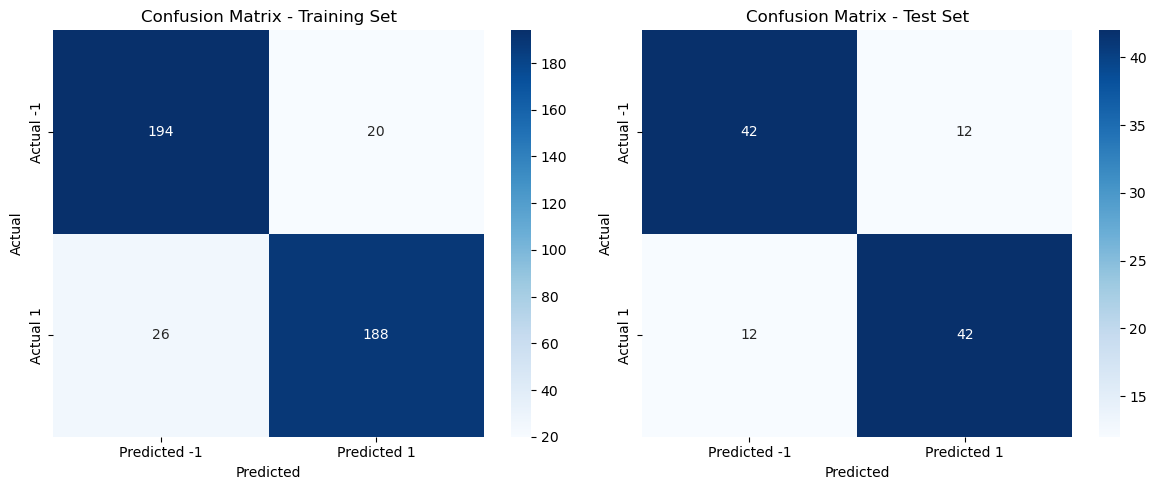

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute confusion matrix
cm_train = confusion_matrix(y_train, y_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted -1', 'Predicted 1'], yticklabels=['Actual -1', 'Actual 1'])
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted -1', 'Predicted 1'], yticklabels=['Actual -1', 'Actual 1'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

(300,) (300,)


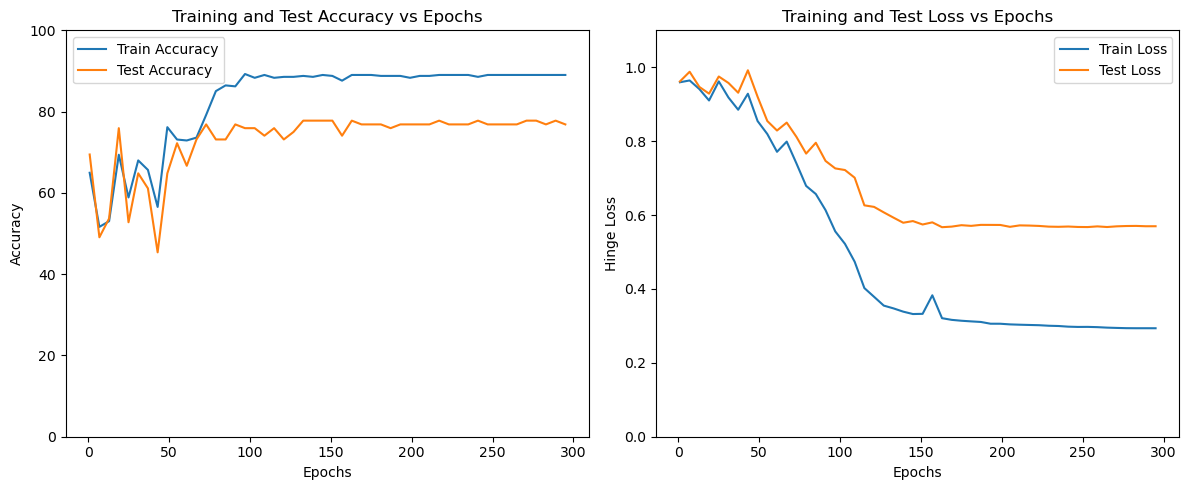

In [56]:
import matplotlib.pyplot as plt

step = 6
epoches = [i for i in range(1, 301)]
train_accuracies = svm.train_accuracies
test_accuracies = svm.test_accuracies
train_losses = np.array(svm.train_losses) / len(y_train)
test_losses = np.array(svm.test_losses) / len(y_test)

print(np.array(train_losses).shape, np.array(test_losses).shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoches[::step], train_accuracies[::step], label='Train Accuracy')
plt.plot(epoches[::step], test_accuracies[::step], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epoches[::step], train_losses[::step], label='Train Loss')
plt.plot(epoches[::step], test_losses[::step], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Hinge Loss')
plt.ylim(0, 1.1)
plt.title('Training and Test Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epoches, train_losses, label='Train Loss')
plt.plot(epoches, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Hinge Loss')
plt.ylim(0, 1.1)
plt.title('Training and Test Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Grid Search

In [21]:
C = [0.8, 0.9, 1.0, 1.1]
gamma = [0.7, 0.8, 0.9, 1.0, 1.1]
vals = []
for c in C:
    vals.append([])
    for g in gamma:    
        svm = SVM()
        svm.train(X_train.T, y_train, C=c, tol=1e-4, maxIter=300, kernel='rbf', gamma=g)
        y_pred = np.array([np.sign(svm.predict(bob)) for bob in X_train])
        y_test_pred = np.array([np.sign(svm.predict(bob)) for bob in X_test])
        train_accuracy = np.mean(y_pred == y_train)*100
        test_accuracy = np.mean(y_test_pred == y_test)*100
        print(f"C: {c}, Gamma: {g} Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%")
        vals[-1].append([train_accuracy, test_accuracy])


C: 0.8, Gamma: 0.7 Train Accuracy: 85.2803738317757%, Test Accuracy: 75.0%
C: 0.8, Gamma: 0.8 Train Accuracy: 86.91588785046729%, Test Accuracy: 74.07407407407408%
C: 0.8, Gamma: 0.9 Train Accuracy: 87.38317757009347%, Test Accuracy: 75.0%
C: 0.8, Gamma: 1.0 Train Accuracy: 88.08411214953271%, Test Accuracy: 75.92592592592592%
C: 0.8, Gamma: 1.1 Train Accuracy: 89.01869158878505%, Test Accuracy: 76.85185185185185%
C: 0.9, Gamma: 0.7 Train Accuracy: 85.98130841121495%, Test Accuracy: 75.92592592592592%
C: 0.9, Gamma: 0.8 Train Accuracy: 87.38317757009347%, Test Accuracy: 75.0%
C: 0.9, Gamma: 0.9 Train Accuracy: 88.08411214953271%, Test Accuracy: 75.0%
C: 0.9, Gamma: 1.0 Train Accuracy: 89.01869158878505%, Test Accuracy: 76.85185185185185%
C: 0.9, Gamma: 1.1 Train Accuracy: 89.25233644859813%, Test Accuracy: 76.85185185185185%
C: 1.0, Gamma: 0.7 Train Accuracy: 85.74766355140187%, Test Accuracy: 74.07407407407408%
C: 1.0, Gamma: 0.8 Train Accuracy: 87.38317757009347%, Test Accuracy: 75.0

KeyboardInterrupt: 

In [31]:
print(np.array(vals).shape)

(4, 5, 2)


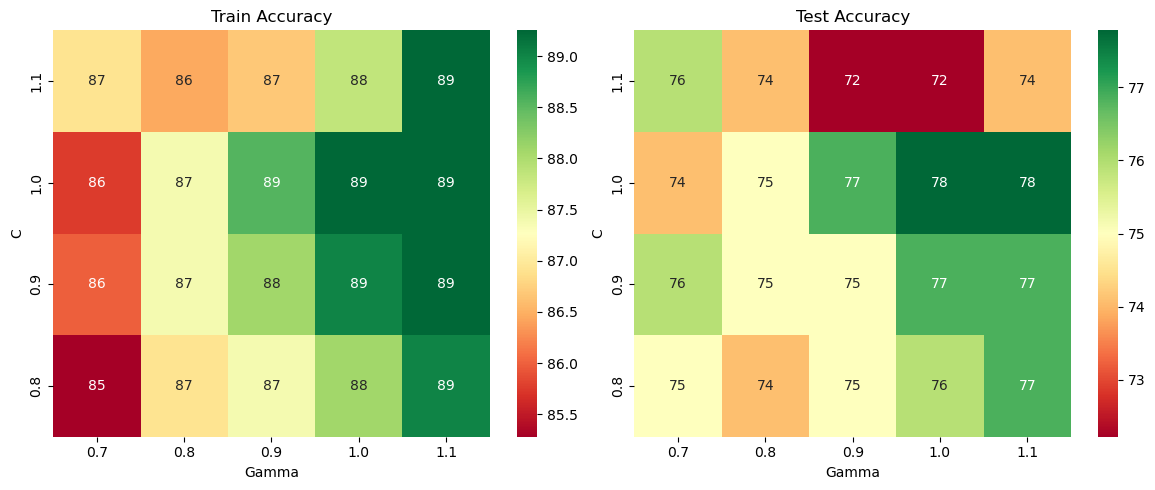

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract train and test accuracies
train_accuracies = np.array([[vals[i][j][0] for j in range(len(gamma))] for i in range(len(C))])
test_accuracies = np.array([[vals[i][j][1] for j in range(len(gamma))] for i in range(len(C))])

# Plot heatmap for train accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(train_accuracies, annot=True, xticklabels=gamma, yticklabels=C, cmap='RdYlGn')
plt.title('Train Accuracy')
plt.xlabel('Gamma')
plt.ylabel('C')

plt.tight_layout()
plt.gca().invert_yaxis()

# Plot heatmap for test accuracies
plt.subplot(1, 2, 2)
sns.heatmap(test_accuracies, annot=True, xticklabels=gamma, yticklabels=C, cmap='RdYlGn')
plt.title('Test Accuracy')
plt.xlabel('Gamma')
plt.ylabel('C')

plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [66]:
import pickle

with open('svm.pkl', 'wb') as f:
    pickle.dump(svm, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

playaround

In [3]:
from sklearn.datasets import make_moons

def plot_decision_boundary(svm, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = np.array([svm.predict(np.array([x, y])) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    ax.set_title(title)

# Generate a moon dataset of size 100
X, y = make_moons(n_samples=100, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.where(y == 1, 1, -1)

for g in [50]:
    svm = SVM()
    svm.train(X.T, y, X.T, y, C=1, tol=1e-4, maxIter=300, kernel='rbf', gamma=g)

    # Plot decision boundary
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_decision_boundary(svm, X, y, ax, 'Decision Boundary for Moon Dataset')
    plt.show()

NameError: name 'plt' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# Generate a dataset with a complex decision boundary
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.where(y == 1, 1, -1)




# Train SVM and plot decision boundary for different values of gamma
C = 1
gammas = [0.1, 1, 5]
fig, axes = plt.subplots(1, len(gammas), figsize=(18, 5))

for i, gamma in enumerate(gammas):
    svm = SVM()
    svm.train(X.T, y, X.T, y, C=C, tol=1e-4, maxIter=300, kernel='rbf', gamma=gamma)
    plot_decision_boundary(svm, X, y, axes[i], f'C={C}, gamma={gamma}')

plt.tight_layout()
plt.show()